In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Set up the reaction graph from DFT data 

In [29]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

#### 2. Sample the `graph`

In [30]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

1008it [00:46, 21.71it/s]                         


#### 3. generate reaction statistics

In [33]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(20)

1 H2 + 1 SO2 = 1 O2 + 1 H2S         954
1 H2O + 1 SO2 = 1 H2SO3             862
3 H2 + 1 SO2 = 2 H2O + 1 H2S        409
2 O2 + 1 H2S = 1 H2SO4              403
3 O2 + 2 H2S = 2 H2O + 2 SO2        359
1 H2 + 1 O2 + 1 SO2 = 1 H2SO4       351
2 H2 + 1 O2 = 2 H2O                 252
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2      241
8 H2O + 1 S8 = 2 H2SO4 + 6 H2S      188
16 H2O + 3 S8 = 16 H2S + 8 SO2      183
1 H2 + 1 H2SO4 = 1 H2O + 1 H2SO3    120
3 O2 + 2 H2S = 2 H2SO3               83
3 H2 + 1 H2SO3 = 3 H2O + 1 H2S       67
4 O2 + 8 H2S = 8 H2O + 1 S8          55
2 H2 + 2 SO2 = 1 H2SO4 + 1 H2S       55
8 O2 + 1 S8 = 8 SO2                  44
1 O2 + 2 H2O + 2 SO2 = 2 H2SO4       44
4 H2SO4 + 1 S8 = 4 H2S + 8 SO2       39
8 O2 + 8 H2O + 1 S8 = 8 H2SO3        24
2 H2 + 1 O2 + 2 SO2 = 2 H2SO3        24
dtype: int64

#### 4. generate mean concentrations and differences

In [34]:
average_data = pd.DataFrame(analysis.average_sampling(data))
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.sort_values(by='diff',inplace=True)
print(average_data.round(2).to_string())

       initial   mean  diff   sem   std    var
O2        10.0   1.65 -8.35  0.05  3.69  13.58
H2S       10.0   3.97 -6.03  0.05  3.31  10.98
H2O       30.0  26.50 -3.50  0.09  6.27  39.28
S8         0.0   0.00  0.00  0.00  0.00   0.00
SO2       10.0  10.05  0.05  0.09  6.12  37.40
H2SO4      0.0   2.14  2.14  0.05  3.20  10.26
H2         0.0   3.55  3.55  0.07  4.71  22.20
H2SO3      0.0   3.84  3.84  0.07  5.13  26.37


#### 5. Plot 

/var/folders/40/xmstzxyn7377k__pn0yxn6w80000gn/T/ipykernel_30880/949321809.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(name='RdBu')  # or any other colormap


<Axes: >

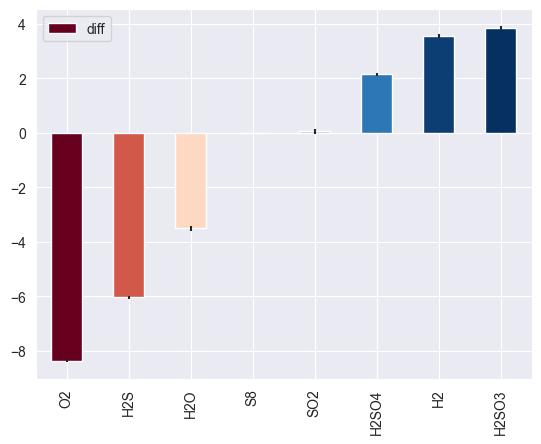

In [35]:
import seaborn as sns 
from matplotlib.cm import get_cmap
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(
    vmin=average_data['diff'].min(), vmax=average_data['diff'].max()
    )
cmap = get_cmap(name='RdBu')  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='sem',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [38]:
pyvis_kwargs = {'width':'50%','notebook':False,"font_color":'white','directed':True}
g = analysis.result_to_pyvis(data,head=20,**pyvis_kwargs)
g.save_graph(name="example_pyvis_graph.html")

In [37]:
! open example_pyvis_graph.html